# **Cox Proportional Hazards Model** 

The Cox Proportional Hazards Model (Cox PH) is a type of survival analysis model, which differs from traditional GLMs, ML models, and time series models in that it is designed to model the time until an event occurs (e.g., loan default, churn, death).

Similar to GLMs: It assumes a linear relationship between predictors and the log of the hazard function. Different from GLMs: It does not assume a specific distribution for survival times (semi-parametric). Different from ML models: It is interpretable and doesn’t require extensive tuning, unlike random forests or neural networks. Different from Time Series Models: It does not predict future values over time but rather the likelihood of an event happening over time, given covariates.

$h(t|X) = h_0 e^{\beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_n X_n}$
- where h(t|X) is the hazard function at time $t$ given covariates $X$ 
- and $h_0$ is the baseline hazard function.


In [23]:
import os

from lifelines import CoxPHFitter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from src.config import CREDIT_RISK_DATA_DIR

In [24]:
os.chdir(CREDIT_RISK_DATA_DIR)

df = pd.read_csv("credit_risk_dataset.csv")
duration = "cb_person_cred_hist_length"
target = "loan_status"

In [26]:
x_numeric_cols = [
    "person_age",
    "person_income",
    "person_emp_length",
    "loan_int_rate",
    "loan_percent_income",
]
x_categorical_col = "loan_grade"

In [27]:
scaler = StandardScaler()

for vars in x_numeric_cols:
    df[f"{vars}_scaled"] = scaler.fit_transform(df[[vars]])

In [28]:
encoder = OneHotEncoder()

series = df[x_categorical_col]
df = pd.get_dummies(data=df, columns=[x_categorical_col], drop_first=True)
df[x_categorical_col] = series

In [32]:
transformed_feature_variables = [
    "person_age_scaled",
    "person_income_scaled",
    "loan_grade_B",
    "loan_grade_C",
    "loan_grade_D",
    "loan_grade_E",
    "loan_grade_F",
    "loan_grade_G",
]

full_df = df[transformed_feature_variables + [target, duration]]

In [34]:
# 2️⃣ Train-Test Split
train_df, test_df = train_test_split(full_df, test_size=0.2, random_state=42)
train_df

,person_age_scaled,person_income_scaled,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,loan_status,cb_person_cred_hist_length
32377,5.712903,-0.323881,False,True,False,False,False,False,0,24
1338,-0.273252,-0.646554,False,False,False,True,False,False,1,3
7047,-0.745843,-0.243213,False,True,False,False,False,False,0,3
8225,-0.903374,-0.162480,False,False,False,False,False,False,0,4
7178,-0.588313,0.208530,False,True,False,False,False,False,0,3
...,...,...,...,...,...,...,...,...,...,...
29802,1.774643,-0.444884,False,True,False,False,False,False,0,17
5390,-0.430783,0.047193,False,False,False,False,False,False,1,4
860,-0.273252,1.321754,False,False,False,True,False,False,1,3
15795,-0.273252,1.757363,False,True,False,False,False,False,0,3


In [35]:
# 3️⃣ Fit Cox Proportional Hazard Model
cph = CoxPHFitter()
cph.fit(train_df, duration_col=duration, event_col=target)

<lifelines.CoxPHFitter: fitted with 26064 total observations, 20401 right-censored observations>

In [36]:
# 4️⃣ Model Summary
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 26064 total observations, 20401 right-censored observations>
             duration col = 'cb_person_cred_hist_length'
                event col = 'loan_status'
      baseline estimation = breslow
   number of observations = 26064
number of events observed = 5663
   partial log-likelihood = -47896.60
         time fit was run = 2025-07-04 15:02:16 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                             
person_age_scaled    -1.58      0.21      0.03           -1.64           -1.52                0.19                0.22
person_income_scaled -1.00      0.37      0.03           -1.07           -0.94                0.34                0.39
loan_grade_B          0.47      1.60      0.04            0.38            0.55                1.47                1.74
loan_grade_C          0.67      1.96      0.05            0.58            0.76                1.79                2.14
loan_grade_D          1.84      6.28      0.04            1.76            1.92                5.78                6.82
loan_grade_E          2.04      7.68      0.06            1.93            2.15                6.87                8.59
loan_grade_F          2.25      9.46      0.09            2.07            2.43                7.89               11.36
loan_grade_G          2.46     11.67      0.15            2.17            2.74                8.74               15.56

                      cmp to      z      p  -log2(p)
covariate                                           
person_age_scaled       0.00 -54.64 <0.005       inf
person_income_scaled    0.00 -30.11 <0.005    659.27
loan_grade_B            0.00  10.73 <0.005     86.88
loan_grade_C            0.00  14.62 <0.005    158.40
loan_grade_D            0.00  43.82 <0.005       inf
loan_grade_E            0.00  35.80 <0.005    930.11
loan_grade_F            0.00  24.18 <0.005    426.56
loan_grade_G            0.00  16.70 <0.005    205.67
---
Concordance = 0.86
Partial AIC = 95809.20
log-likelihood ratio test = 9504.74 on 8 df
-log2(p) of ll-ratio test = inf

In [38]:
# 5️⃣ Predictions on Test Set
test_df["risk_score"] = cph.predict_partial_hazard(test_df)
print(test_df[[duration, target, "risk_score"]].head())

       cb_person_cred_hist_length  loan_status  risk_score
14668                           2            0    4.291057
24614                          10            0    1.388845
11096                           3            0    5.025100
10424                           2            1    3.448745
26007                           6            1    3.544754


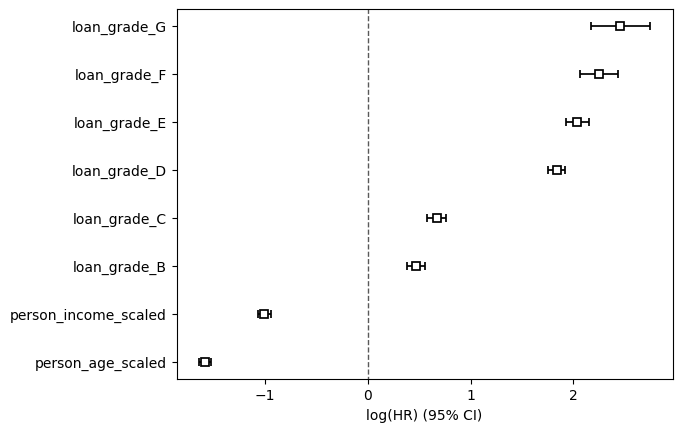

In [39]:
# 6️⃣ Plot Survival Curve for Different Risk Groups
cph.plot()
plt.show()

## **Extra Reading**

https://medium.com/@kylejones_47003/predictive-maintenance-modeling-time-to-failure-using-survival-analysis-in-python-turbofan-35dac4415bac